In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob

from PIL import Image

import torch
import torch.nn as nn

import torchvision
from torchvision.models import *
from torchvision.datasets import ImageFolder


!pip install saliency tensorflow #install a package including XRAI
import saliency.core as saliency

!pip install grad-cam
from pytorch_grad_cam.utils.image import show_cam_on_image #Grad-CAM & XRAI heatmap

!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 7.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38241 sha256=fb86a57851bdcda3f5c55eb66a64ff9d365b253371a38301eb40d71cf2e306e0
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam
Mon Jun 12 06:25:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|--------------------------

In [ ]:
#
# mount my Google Drive
#
from google.colab import drive
drive.mount('/content/drive')

# move to working dir
%cd /content/drive/MyDrive/'Colab Notebooks'/20210910_Ueda-lab_VGG16_Marchantia_classifier/20220510_additional_data
!ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/20210910_Ueda-lab_VGG16_Marchantia_classifier/20220510_additional_data
 20220519_test_accuracy.ipynb
 20220626_loss_multilabel_test.ipynb
 20220626_MF2classes_testdata_forLoop.ipynb
'20220626_MF2classes_testdata_forLoop.ipynb のコピー'
 20220701_PCAs_original_images.ipynb
 20220701_PCAs_ResNet50GAP.ipynb
 20220701_plot_day-test_acc.ipynb
 20220720_MF2classes_rotatedTestdata.ipynb
 20220721_test_Grad-CAM.ipynb
 20220809_MF2classes_testdata_multilabel.ipynb
 20220819_Grad-CAM_IoU.ipynb
 20220917_Marchantia_imgs_Paper.ipynb
 20220930_make_datafiles_tSNE.ipynb
 20221018_MF2classes_label_randomize.ipynb
 20221021_plot_day-test_acc_randomLabels.ipynb
 20221102_MF2classes_testdata_ablation_centermask.ipynb
 20221102_MF2classes_testdata_resize.ipynb
 20221115_pytorch_to_tensorflow.ipynb
 20221129_MF2classes_testdata_forLoop_Tak.ipynb
 20221201_plot_day-test_acc_Tak.ipynb
 20221212_plot_ablation-testacc_Tak.ipynb
 20221214_plot_area.

In [ ]:
from utils.loaders import Args, ImageTransform, MarchantiaDataset, get_data, indices_to_loader
from utils.misc import get_unnormalize, get_datetime, makedirs, set_requires_grad_toFalse, compute_loss
from utils.misc import visualize_batch
from utils.misc import display_loss_acc, predict_testloader, test_loadedModel

from utils.cams import calculate_cam, input_to_img


from utils import xrai

In [ ]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')
  plt.imshow(im)
  if title!=None:
    plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')

  plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
  plt.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')
  plt.imshow(im, cmap='inferno')
  plt.title(title)

def LoadImage(file_path):
  im = Image.open(file_path)
  im = im.resize((224,224))
  im = np.asarray(im)
  return im

In [ ]:
# Pre-process the image and convert into a tensor
size= 224
transform = torchvision.transforms.Compose([
     torchvision.transforms.Resize(size),
    #  torchvision.transforms.CenterCrop(size),#To Do: imageの短辺に合わせてcentercrop
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]),
 ])

batch_size = 25
class_idx_str = 'class_idx_str'

def min_max_normalization(array_2d: np.ndarray):
  """:input: np.ndarray.shape = (W, H). The grayscale mask.
  """
  normalized = (array_2d - np.min(array_2d))/(np.max(array_2d)-np.min(array_2d))
  return np.float32(normalized)


def call_model_function(images, call_model_args=None, expected_keys=None):
    """
    A function that interfaces with a model to return specific data
        in a dictionary when given an input and other arguments.
    Args:
      images:
        Input image: <class numpy.ndarray>.
      call_model_args:
        a class for which the XRAI calculates the explanation.
        e.g.) call_model_args = {'class_idx_str': 236}. Class #236 is "doberman".
      expected_keys:
        List of keys that are expected in the output. For this method (XRAI),
        the expected keys are INPUT_OUTPUT_GRADIENTS - Gradients of the output being
        explained (the logit/softmax value) with respect to the input.
        Shape should be the same shape as the images.
        e.g.) expected_keys = [INPUT_OUTPUT_GRADIENTS].
    Returns:
        saliency.base.INPUT_OUTPUT_GRADIENTS: gradients
        gradients is numpy.ndarray of the size (batch_size, size(images)).
    """

    target_class_idx =  call_model_args[class_idx_str]
    images = torch.from_numpy(images.astype(np.float32)) # convert to tensor
    images = images.clone().detach().requires_grad_(True)
    images = images.to(dev)

    gradients = []
    with torch.autograd.set_grad_enabled(True):
      if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
        output = model(images)
        grads = torch.autograd.grad(torch.unbind(output[:, target_class_idx]), images)
        grads = grads[0].to('cpu').detach().numpy().copy()
        gradients = np.asarray(grads)
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
      else:
        print("gradients for conv layer are not implemented.")
        return None

def calculate_xrai(input, label, xrai_object,
                   call_model_function=call_model_function, xrai_batch_size=20):
    '''
    ::parameters::
    :input:np.ndarray.shape=(3,244,244)), inputs_test[idx]
    :label:int, 0 or 1 in Marchantia models. The label is converted to call_model_args.
    :call_model_function:
    :xrai:
    :batch_size:20. batch size in computing xrai's IG.
    ::return::
    :xrai_attributions:np.ndarray.shape=(W,H) of np.float32, grayscale mask of the xrai attributions. The mask is min-max-normalized.
    '''
    # xrai_attribution is not normalized. You should apply min_max_normalization afterward.

    call_model_args = {class_idx_str: pred_label}
    xrai_attributions = xrai_object.GetMask(input,
                                            call_model_function=call_model_function,
                                            call_model_args=call_model_args,
                                            batch_size=xrai_batch_size)
    xrai_attributions = min_max_normalization(xrai_attributions)
    return xrai_attributions

# Set up matplot lib figures.
def plot_img_and_overlay(im_orig, mask, upscale_factor):
  ROWS = 1
  COLS = 2
  UPSCALE_FACTOR = upscale_factor
  plt.figure(figsize=(COLS * UPSCALE_FACTOR, ROWS * UPSCALE_FACTOR))

  # Show original image
  ShowImage(im_orig, title=None, ax=plt.subplot(ROWS, COLS, 1))

  # Show XRAI heatmap attributions
  ShowHeatMap(overlay, title=None, ax=plt.subplot(ROWS, COLS, 2))



In [ ]:
import pandas as pd
def test_loadedModel(model_path, model, val_loader, dev, multilabel=False):
    #saved "best val acc" & "loss"
    val_accs = pd.read_csv(model_path + 'val_accs.csv', header=None)
    val_acc = np.max(val_accs)
    val_losses = pd.read_csv(model_path + 'val_losses.csv', header=None)
    val_loss = val_losses.values[np.argmax(val_accs)]
    print('epoch with max validation acc. : ' + str(np.argmax(val_accs)))

    #calculate val acc, loss from loaded model
    loss, acc = compute_loss(model, val_loader, dev, multilabel)
    print(f'loss : {loss}, acc : {acc}')

    ## assert if acc & loss don't match
    assert int((val_acc - acc)*100)==0, 'The accuracy mismatch'
    assert int((val_loss - loss)*100)==0, 'The loss mismatch'

In [ ]:
from typing import NamedTuple
class CamConditionContainer(NamedTuple):
    correct: bool
    pred_label: str
    logits_best: bool

    def get_conditioned_indices(self, strain, outputs, labels, preds):
        '''filer correct/incorrect prediction & male/female'''
        # preds = np.argmax(outputs, axis=1)
        outputs_sub = outputs[:, 0] - outputs[:,1]
        cond1 = (preds == labels) if self.correct==True else (preds != labels) if self.correct==False else None
        if strain == 'Tak':
          cond2 = (outputs_sub < 0) if self.pred_label == 'F' else (outputs_sub > 0) if self.pred_label == 'M' else None# if self.pred_label ==None
        else:
          cond2 = (outputs_sub > 0) if self.pred_label == 'F' else (outputs_sub < 0) if self.pred_label == 'M' else None# if self.pred_label ==None
        conditioned_indices = np.where(cond1 & cond2)[0]
        return conditioned_indices

cuda
args dict {'size_image': 224, 'batch_size': 32, 'root': '../20220510_additional_data/data/data_original/Tak/7d/', 'model_path': '../20220510_additional_data/results_test/20221228-114318_Tak_7d_original/'}
../20220510_additional_data/results_test/20221228-114318_Tak_7d_original/ResNet50_20221228-114318_8epoch.pt


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Dataset ImageFolder
    Number of datapoints: 200
    Root location: ../20220510_additional_data/data/data_original/Tak/7d/
{'Tak-1_7d_M': 0, 'Tak-2_7d_F': 1}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


epoch with max validation acc. : 8
loss : 0.19652152061462402, acc : 1.0
(40,)
test_acc :  1.0
*
*
*
*
*

pred_label: M


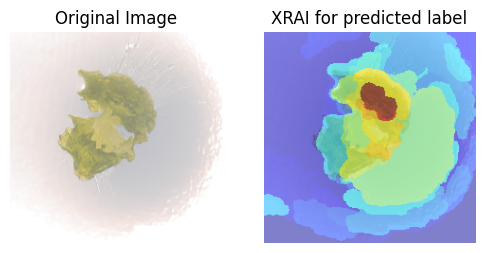

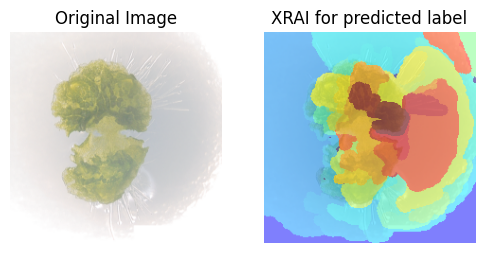

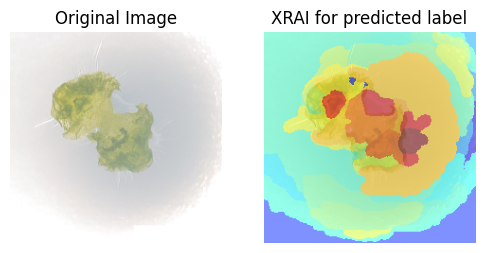

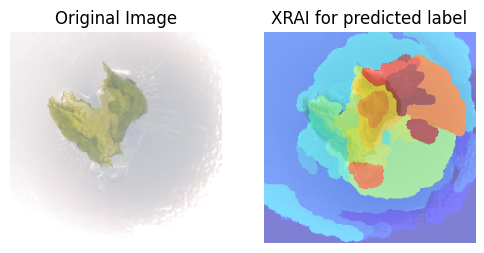

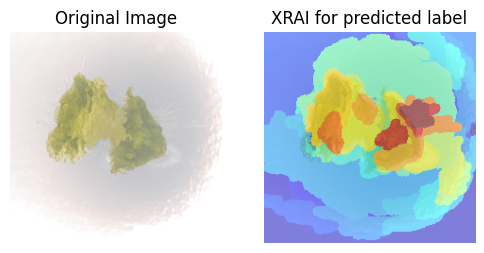

*
*
*
*
*

pred_label: F


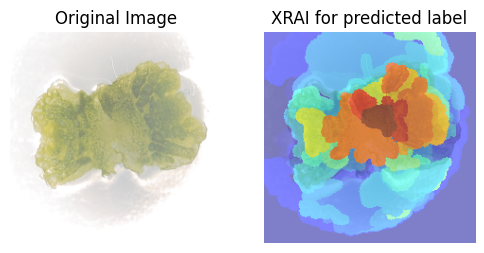

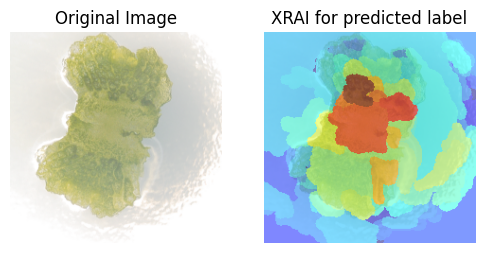

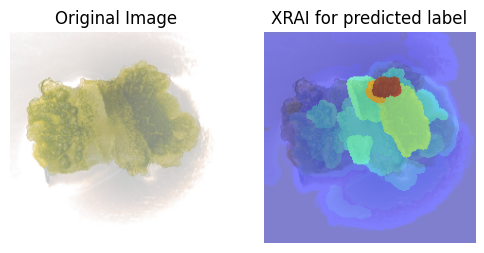

KeyboardInterrupt: ignored

In [ ]:
### Top 5 representative images of correct = True, logit best

strain_list = ['Tak', 'RIL5', 'Aus']
day_list = ['7d', '0d']
ablation = 'original'


dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)


for strain in strain_list:
    figure_path = '../20220510_additional_data/figures/XRAI/' + strain + '/'
    makedirs(figure_path)

    for day in day_list:
        ### path
        args = Args()
        args.root =  '../20220510_additional_data/data/data_' + ablation + '/' + strain + '/' + day + '/'

        i = 0 #model index
        model_path_list = glob('../20220510_additional_data/results_test' + '/*_' + strain + '_' + day + '*/')
        model_path_list.sort()
        args.model_path = model_path_list[i]
        print('args dict', args.__dict__)

        # load model
        model_fname = glob(args.model_path + '*.pt')[0]
        print(model_fname)

        model = resnet50(pretrained=True) #"pretrained" will be deprecated. Use "weights" instead.
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
        model.load_state_dict(torch.load(model_fname, map_location=torch.device('cpu')))
        ## model.eval()
        model.to(dev)

        # load a dataset
        Transform = ImageTransform(fill=0)
        full_dataset = ImageFolder(root=args.root)

        print(full_dataset)
        print(full_dataset.class_to_idx)
        dataset_noaug = MarchantiaDataset(full_dataset, Transform.data_transform["valid"])
        val_loader = indices_to_loader(args.model_path, 'indices_val.csv', dataset_noaug, batch_size=args.batch_size)
        test_loader = indices_to_loader(args.model_path, 'indices_test.csv', dataset_noaug, batch_size=args.batch_size)

        test_images, _ = next(iter(test_loader))
        # visualize_batch(test_images); plt.show()
        # display_loss_acc(args.model_path); plt.show()
        test_loadedModel(args.model_path, model, val_loader, dev, multilabel=False)
        inputs_test, labels_test, outputs_test, preds_test = predict_testloader(model, test_loader, dev)
        print(preds_test.shape)
        print('test_acc : ', preds_test[preds_test == labels_test].shape[0]/preds_test.shape[0])


        for pred_MF in ['M','F']:
            print('*\n*\n*\n*\n*\n')
            print('pred_label:', pred_MF)
            condition = CamConditionContainer(correct=True, pred_label=pred_MF, logits_best=True)
            idx_list = condition.get_conditioned_indices(strain, outputs_test, labels_test, preds_test)
            outputs_sub = outputs_test[:, 0] - outputs_test[:,1]

            ### index
            subset_idx_sorted = np.argsort(np.abs(outputs_sub[idx_list]))[::-1] if condition.logits_best == True else np.argsort(np.abs(outputs_sub[idx_list])) if condition.logits_best == False else idx_list
            conditioned_idx_sorted = idx_list[subset_idx_sorted]

            ### for plotting original image
            transform_unnormalize = get_unnormalize()
            inputs_test_unnorm = transform_unnormalize(torch.from_numpy(inputs_test))
            inputs_test_unnorm = inputs_test_unnorm.cpu().detach().numpy().copy()

            for i_figure, idx in enumerate(conditioned_idx_sorted[:5]):
                input = inputs_test[idx] #input data for XRAI. numpy array of size (3,224,224)
                pred_label = labels_test[idx]
                # print("Prediction class: " + str(pred_label))  # 0 or 1
                # outputs_test[idx]

                ### XRAI - Full
                # Construct the saliency object. This alone doesn't do anthing.
                xrai_object = xrai.XRAI() #overrode

                ## pred_classについてのXRAI
                xrai_attributions = calculate_xrai(input, pred_label, xrai_object, call_model_function)

                # plot
                im_orig = inputs_test_unnorm[idx].transpose(1,2,0)
                mask = np.tile(xrai_attributions,(3,1,1)).transpose(1,2,0) #transform from 2D to 3D (shape=(3, size, size))
                overlay = show_cam_on_image(im_orig, mask, use_rgb=True)


                plot_img_and_overlay(im_orig, mask, upscale_factor=3)

                # figure title
                if condition.correct:
                    label = condition.pred_label
                else:
                    label = 'M' if condition.pred_label=='F' else 'F' if condition.pred_label=='M' else None
                fname = strain + '_day' + day[0] + '_label' + label + '_pred' +condition.pred_label + '_' + str(i_figure+1)
                # print(figure_path + fname + '.pdf')
                plt.savefig(figure_path + 'pdf_' + fname + '.pdf', dpi=300)
                plt.savefig(figure_path + 'png_' + fname + '.png', dpi=300)
                plt.show()
